Calvin Bales\
Phys2600 Homework 3\
Collaborated with Erin Morissette

1)  Consider the one-dimensional, time-independent Schrodinger equation for a harmonicoscillator with potential $V(x) =V_0x^2/a^2$ where $V_0$ and $a$ are constants. 

$$\Psi(x;t)=\psi(x)\phi(t)$$ \
$$\phi(t)=e^{iEt/\hbar}$$ \
$$-\frac{\hbar^2}{2m} \frac{\partial^2 \psi}{\partial x^2}+ V(x)\psi = E \psi \rightarrow - \frac{\hbar^2}{2m} \frac{\partial^2\psi}{\partial x^2}+V_0\frac{x^2}{a^2}\psi = E\psi$$ \
Convert second order differential equation into two first order ones:\
$$\frac{d\psi}{dx}=u$$  $$\frac{du}{dx}=\frac{2m}{\hbar^2}\left(E-V_0\frac{x^2}{a^2}\right)\psi $$ 
Make $x$ dimmensionless:
$$ x=\left(\hbar^2a^2\over 2mV_0\right)^{1/4}\xi = B\xi \;\;\;\;\; B \equiv \left(\frac{h^2a^2}{2mV_0}\right)^{1/4} $$
$$ \frac{d}{dx}=\frac{d\xi}{dx}\frac{d}{dx}\rightarrow\frac{d\xi}{dx}=B\frac{d}{dx}$$

\newcommand*{\frac}[1]{% \fr@aux#1,,\@nil}

$$\Psi(x;t)=\psi(x)\phi(t)$$ \
$$\phi(t)=e^{iEt/\hbar}$$ \
$$-\hbar^2\over{2m}$$

\frac{1,2}

In [7]:
#%matplotlib notebook
import numpy as np
from scipy.integrate import odeint
import rootfinder as rtf
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from numba import jit

In [22]:
class QM(object):
    def __init__(self, E, npoints, x_start, x_end = 0, u0 = 0.0, v0 = 0.01):
        self.E = E
        self.npoints = npoints
        self.uv0 = np.array([u0, v0]) # NumPy array with initial position and velocity
        V0 = 50
        a = 1e-11
        hbar = 6.582e-16
        m = 9.1e-31
        J_eV = 6.242e18
        self.E_fact=np.sqrt(J_eV*2*m*a**2/((hbar**2)*V0))
       
        # always want to start at furthest point and go to zero
        self.xarray = np.linspace(x_start, x_end, npoints, endpoint = True) # include final timepoint

    def scipy_trajectory(self):
        """calculate trajectory using SciPy ode integrator"""
        self.uv = odeint(self.sch, self.uv0, self.xarray)
        self.uv_end = self.uv[-1]

    def sch(self, uv, x):
        """right hand side of the differential equation"""
        u = uv[1]
        v = (self.Potential(x) - self.E*self.E_fact)*uv[0]
        return np.ravel(np.array([u, v]))

    def Potential(self, x):
        return x**2

In [23]:
# the matching function
def match(En):
    #a = 1.0e-11
    p_up = QM(E = En, npoints = 1000, x_start = -10) # up from -inf (psi left)
    p_down = QM(E = En, npoints = 1000, x_start = 10) # down from +inf (psi right)
    p_up.scipy_trajectory() 
    p_down.scipy_trajectory()

    return p_down.uv_end[0]*p_up.uv_end[1] - p_down.uv_end[1]*p_up.uv_end[0]

Energy found: 138.08462
Energy found: 414.25386
Energy found: 690.42309
Energy found: 966.59233
Energy found: 1242.76157
Energy found: 1518.93081
Energy found: 1795.10004
Energy found: 2071.26928
Energy found: 2347.43852
Energy found: 2623.60775
[4.93480220e+22 4.44132198e+23]


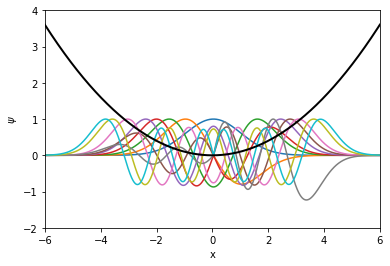

In [24]:
a = 1e-11
E1 =  100 # start Energy search at the well depth
dE = 1
npoints = 1000

E_SM = []

fig = plt.figure()
ax = fig.add_subplot(111)

# Bound states must have E < 0 for the square well. 
# Cut off after we have found a few states
while (E1 < 2700-dE):
    
    if match(E1)*match(E1 + dE) < 0 :  # bracket E
        # find the energy
        E = rtf.bisect(match, E1, E1+dE, 1e-12)
        print('Energy found: %.5f'%(E))
        E_SM.append(E)
        
        dx = 16*a/npoints
        
        # for plotting, must ensure overlap of left and right solutions 
        p_up = QM(E, npoints = npoints+4, x_start = -10, x_end = 0+4*dx)
        p_down = QM(E, npoints = npoints-4, x_start = 10, x_end = 0+4*dx)
        
        p_up.scipy_trajectory()
        p_down.scipy_trajectory()
        
        # scale factor
        scale = p_up.uv_end[0]/p_down.uv_end[0]
        
        # full solution, combine up and down solutions
        psi_x = np.concatenate((p_up.uv[:-1,0], scale*p_down.uv[::-1,0]))
        xa = np.linspace(-10,10, 2*npoints-1, endpoint = True)
        
        # plot the scaled solution (not normalized), scale maximum to 1 for plotting purposes
        ax.plot(xa, psi_x/max(psi_x))
    #else : 
    #    print("No bracket, increasing energy to", E1+dE)
    E1 += dE

# Solution is exact only for for wide and deep well, and odd n 
a = 1e-11
V0 = 50
n = np.arange(1,5,2)
Exact = -V0+np.pi**2/2/a**2*n**2
print(Exact)

# plot the potential
ax.plot(xa, np.vectorize(p_up.Potential)(xa)/10., color = 'k', lw =2)
ax.set_xlim([-6, 6])
ax.set_ylim([-2,4])
ax.set_xlabel('x')
ax.set_ylabel('$\psi$')
plt.show()

b) aharmonic potential

In [3]:
class QM_anharm(object):
    def __init__(self, E, npoints, x_start, x_end = 0, u0 = 0.0, v0 = 0.01):
        self.E = E
        self.npoints = npoints
        self.uv0 = np.array([u0, v0]) # NumPy array with initial position and velocity
        self.V0 = 50
        self.a = 1e-11
        hbar = 6.582e-16
        m = 9.1e-31
        J_eV = 6.242e18
        self.B=(2*self.V0/self.a**2)**(1/4)
       
        # always want to start at furthest point and go to zero
        self.xarray = np.linspace(x_start, x_end, npoints, endpoint = True) # include final timepoint

    def scipy_trajectory(self):
        """calculate trajectory using SciPy ode integrator"""
        self.uv = odeint(self.sch, self.uv0, self.xarray)
        self.uv_end = self.uv[-1]

    def sch(self, uv, x):
        """right hand side of the differential equation"""
        u = uv[1]
        v = (self.Potential(x) - 2*self.E/self.B**2)*uv[0]
        return np.ravel(np.array([u, v]))

    def Potential(self, x):
        return (x**2)+x**4*self.B**2/(20*self.V0)

In [4]:
# the matching function
def match(En):
    #a = 1.0e-11
    p_up = QM_anharm(E = En, npoints = 1000, x_start = -10) # up from -inf (psi left)
    p_down = QM_anharm(E = En, npoints = 1000, x_start = 10) # down from +inf (psi right)
    p_up.scipy_trajectory() 
    p_down.scipy_trajectory()

    return p_down.uv_end[0]*p_up.uv_end[1] - p_down.uv_end[1]*p_up.uv_end[0]

/Users/calvin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/calvin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply
/Users/calvin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


Energy found: 106.00000
Energy found: 111.00000
Energy found: 127.00000
Energy found: 169.00000
Bisection error: no root bracketed


TypeError: must be real number, not NoneType

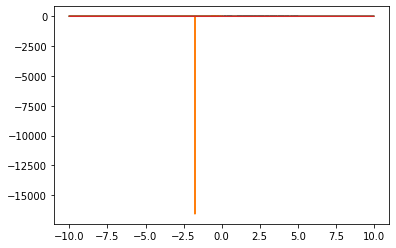

In [6]:
a = 1e-11
E1 = 100 # start Energy search at the well depth
dE = 1
npoints = 1000

E_SM = []

fig = plt.figure()
ax = fig.add_subplot(111)

# Bound states must have E < 0 for the square well. 
# Cut off after we have found a few states
while (E1 < 200-dE):
    
    if match(E1)*match(E1 + dE) < 0 :  # bracket E
        # find the energy
        E = rtf.bisect(match, E1, E1+dE, 1e-12)
        print('Energy found: %.5f'%(E))
        E_SM.append(E)
        
        dx = 16*a/npoints
        
        # for plotting, must ensure overlap of left and right solutions 
        p_up = QM_anharm(E, npoints = npoints+4, x_start = -10, x_end = 0+4*dx)
        p_down = QM_anharm(E, npoints = npoints-4, x_start = 10, x_end = 0+4*dx)
        
        p_up.scipy_trajectory()
        p_down.scipy_trajectory()
        
        # scale factor
        scale = p_up.uv_end[0]/p_down.uv_end[0]
        
        # full solution, combine up and down solutions
        psi_x = np.concatenate((p_up.uv[:-1,0], scale*p_down.uv[::-1,0]))
        xa = np.linspace(-10,10, 2*npoints-1, endpoint = True)
        
        # plot the scaled solution (not normalized), scale maximum to 1 for plotting purposes
        ax.plot(xa, psi_x/max(psi_x))
    #else : 
    #    print("No bracket, increasing energy to", E1+dE)
    E1 += dE

# Solution is exact only for for wide and deep well, and odd n 
a = 1e-11
V0 = 50
n = np.arange(1,5,2)
Exact = -V0+np.pi**2/2/a**2*n**2
print(Exact)

# plot the potential
ax.plot(xa, np.vectorize(p_up.Potential)(xa)/10., color = 'k', lw =2)
ax.set_xlim([-6, 6])
ax.set_ylim([-2,4])
ax.set_xlabel('x')
ax.set_ylabel('$\psi$')
plt.show()

Problem 2-

In [28]:
def box(phi):
    """ 
    define parallel plate potential
    """
   # the operator // is floor division i.e divide and then round down to nearest integer.
   # Using this ensures that the result is an integer so we can use it to index arrays.
    
    n, m = np.shape(phi)
    w = n//2
    h = n//4  # span 1/3 of grid in height
    j = n//20
    
    right = w + h #position of plate 1
    left = w - h  # position of plate 2
    right_in = w+j
    left_in = w-j
    
    phi[h:3*h, left] = 0
    phi[h:3*h, right] = 0
    phi[h, left:right] = 0
    phi[3*h, left:right] = 0
    phi[9*j:11*j, left_in] = 1
    phi[9*j:11*j, right_in] = 1
    phi[9*j, left_in:right_in] = 1
    phi[11*j, left_in:right_in] = 1
    
    return phi

In [29]:
@jit
def jacobi(V,Vnew,M,N):
    for ii in range(M):
        for jj in range(N):
            if ii == 0 or jj == 0 or ii == M or jj == N:
                Vnew[ii,jj] = V[ii,jj]
            else :
                Vnew[ii,jj] = (V[ii+1,jj]+V[ii-1,jj]+V[ii,jj+1]+V[ii,jj-1])/4
    return Vnew

def invDel2_loops(b, boundary,  dx=1.0, converge = 1e-6):
    """ This is the Jacobi algorithim 
    Specialized to two dimensions so that plotting is easier.
    """
    V = boundary(np.zeros(b.shape, float))  # potential values at step n of the iteration   
    Vnew = np.zeros(b.shape, float) # updated potential 
    Npoints = len(b.flatten())

    t = 0  # transient before checking for convergence
    dV = converge*10  #make sure we run through transient
    
    while(dV > converge): 
        # move the loops outside to use jit
        Vnew = jacobi(V,Vnew,V.shape[0]-1,V.shape[1]-1)
        
        # enforce bc's at every iteration
        Vnew = boundary(Vnew)


        # wait for transient before checking convergence
        if t > 100 : 
            dV = np.sum(abs(Vnew - V))/Npoints
        # Note the explicit indexing (V[:,:]) without it Vnew will be updated with V
        V[:,:] = Vnew 
        # for mor complex objects i.e. list with sublists use deepcopy
        t+=1
   
    return Vnew

In [30]:
N = 200 #grid points
dx = 1/N

# generate coordinates for each grid point
# only required for plotting E-field
X,Y = np.meshgrid(range(-N//2, N//2+1), range(-N//2, N//2+1))

# the charge distrubution defines space for us
# empty space, no charge
rho = np.zeros([N+1, N+1])
#rho = pipe(rho)*-5000

# solution from relaxation

# using loops
phi = invDel2_loops(rho, box, dx)

# or using array slicing
#phi = invDel2(rho, parallel_plate, dx)


# Calculate the electric field
EY, EX = -1*np.array(np.gradient(phi))
magE = np.sqrt(EX**2 + EY**2)

# Note, this step was not completed in shared notebook, so plots will look a bit messy
# supress division by zero error output
np.seterr(divide = 'ignore', invalid = 'ignore')
EX= np.divide(EX,magE)
EY= np.divide(EY,magE)


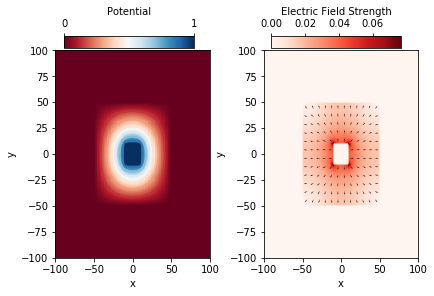

In [31]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# plot potential
m1 = ax1.pcolormesh(X, Y, phi, cmap = 'RdBu')

# add an axes to put colorbar is custom location
cax1 = fig.add_axes([0.14,0.87,0.3,0.04])
# create colorbar
cbar = fig.colorbar(m1,cax1, orientation = 'horizontal', ticklocation = 'top', ticks = [-1,0,1])
cbar.set_label('Potential')

# add contour lines
ax1.contour(X,Y,phi, cmap = 'RdBu')
ax1.set_xlabel("x")
ax1.set_ylabel("y")

# plot E-field 
m2 = ax2.pcolormesh(X,Y,magE, cmap = 'Reds')

cax2 = fig.add_axes([0.62,0.87,0.3,0.04])
cbar2 = fig.colorbar(m2,cax2,orientation = 'horizontal', ticklocation = 'top' )
cbar2.set_label('Electric Field Strength')
ax2.quiver(X[::8,::8],Y[::8,::8],EX[::8,::8], EY[::8, ::8], units = 'width') 
ax2.set_xlabel("x")
ax2.set_ylabel("y")


fig.subplots_adjust(left = 0.12,right = 0.96, bottom = 0.14, top = 0.86,wspace =0.35, hspace = 0.35)
